In [2]:
import sys
sys.path.append("/home/jarlehti/projects/gradu")

In [3]:
import os
import glob
from dataclasses import dataclass
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import d3p
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from src.napsu_mq.napsu_mq import NapsuMQResult
from scripts.constants import TRAIN_DATASET_SIZE_MAP, TRUE_COEFFICIENTS_FOR_DATASETS
from src.napsu_mq.logistic_regression import logistic_regression
from src.napsu_mq.rubins_rules import conf_int, non_negative_conf_int
from src.utils.data_utils import dataframe_list_to_tensor
from src.utils.preprocess_dataset import get_binary4d_train
from src.utils.data_utils import transform_for_classification
import pprint
from scipy.special import expit

In [5]:
CURRENT_FOLDER = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
DATASETS_FOLDER = os.path.join(CURRENT_FOLDER, "data", "datasets")
MODELS = os.path.join(CURRENT_FOLDER, "models")
BU_MODELS_FOLDER = os.path.join(os.path.dirname(CURRENT_FOLDER), "cluster_backup", "gradu_cluster_backup_05042023", "models")

In [4]:
model_files = glob.glob(os.path.join(MODELS, '*.dill'))

In [5]:
pprint.pprint([(i, m) for i, m in enumerate(model_files)])

[(0,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary4d_BC_10e_NUTS.dill'),
 (1,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary4d_AB+BC+CD_30e_NUTS.dill'),
 (2,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary4d_BC_80e_NUTS.dill'),
 (3,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary4d_BC_01e_NUTS.dill'),
 (4,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary4d_AB+BC+CD_01e_NUTS.dill'),
 (5,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary3d_AB+BC+AC_03e_NUTS.dill'),
 (6,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary4d_AB+AC_01e_NUTS.dill'),
 (7,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary4d_BC_30e_NUTS.dill'),
 (8,
  '/home/local/jarlehti/projects/gradu/models/napsu_testing_binary4d_all_queries_500e_NUTS.dill'),
 (9,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary4d_BC+CD_80e_NUTS.dill'),
 (10,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary4d_AB+BC+CD_80e_NUTS.dill'),
 (11,

In [8]:
# Open random model
model_path = os.path.join(model_files[23])
model_binary = open(model_path, "rb")
model = NapsuMQResult.load(model_binary)

In [6]:
model_path = os.path.join(BU_MODELS_FOLDER, "napsu_original_model_binary4d_80e_A+D-B+D-C+D.dill")
model_binary = open(model_path, "rb")
model = NapsuMQResult.load(model_binary)

In [7]:
model.meta

{'experiment_id': 'CVAZLCY9',
 'dataset_name': 'binary4d',
 'query_str': 'A+D-B+D-C+D',
 'query_list': [['A', 'D'], ['B', 'D'], ['C', 'D']],
 'epsilon': 8.0,
 'delta': 1e-10,
 'MCMC_algo': 'NUTS',
 'laplace_approximation': True,
 'missing_query': None,
 'discretization': None,
 'n_canonical_queries': 7,
 'junction_tree_width': 2,
 'suff_stat_dim': (7,),
 'laplace_approximation_algorithm': 'torch_LBFGS'}

In [8]:
dataset_name = model.meta['dataset_name']
n_original_datapoints = TRAIN_DATASET_SIZE_MAP[dataset_name]
print(n_original_datapoints)
true_params = TRUE_COEFFICIENTS_FOR_DATASETS[dataset_name]
print(true_params)

100000
[1.0, 0.0, 2.0]


In [9]:
orig_df = pd.read_csv(os.path.join(DATASETS_FOLDER, "binary4d.csv"))

In [10]:
orig_df

,A,B,C,D
0,0,0,1,1
1,0,1,0,0
2,0,0,0,1
3,1,1,0,1
4,0,1,0,1
...,...,...,...,...
99995,1,1,1,1
99996,0,0,0,0
99997,0,0,1,1
99998,0,1,0,1


In [11]:
orig_df_np = orig_df.to_numpy()
print(np.mean(orig_df_np, axis=0))

X_array_orig = orig_df_np[:,:-1]
y_array_orig = orig_df_np[:,-1]
lr_model_orig = sm.GLM(y_array_orig, X_array_orig, family=sm.families.Binomial()).fit()
print(lr_model_orig.summary())

[0.50061 0.49617 0.49991 0.76634]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -45695.
Date:                Thu, 13 Apr 2023   Deviance:                       91390.
Time:                        14:27:31   Pearson chi2:                 9.99e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1592
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0

In [12]:
original_params = lr_model_orig.params
print(original_params)

[ 1.01686765 -0.00484748  1.99702816]


Generating data with 100000 points and 100 datasets


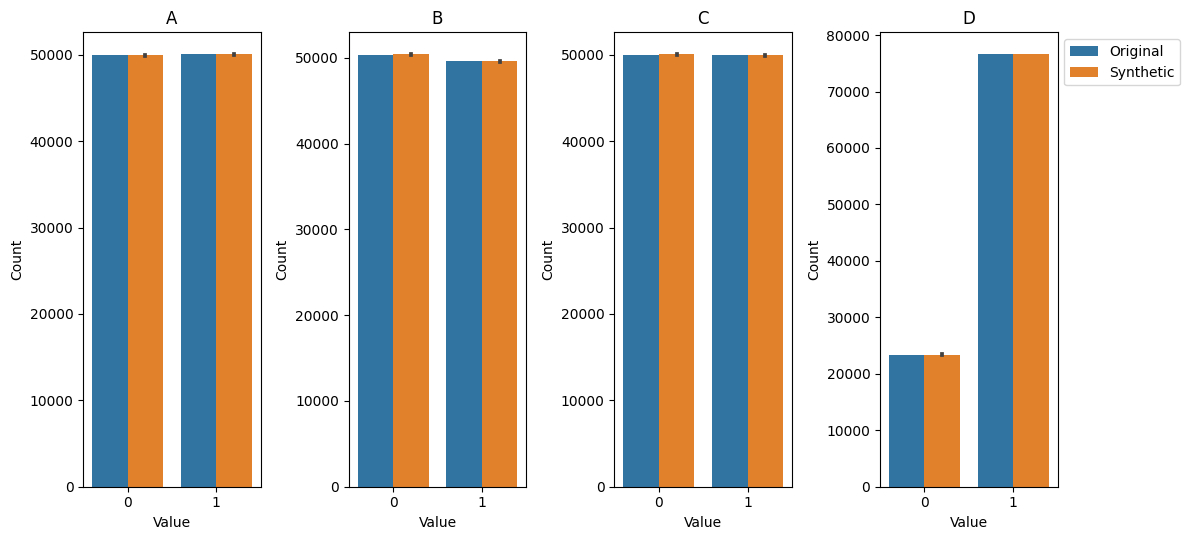

In [13]:
rng = jax.random.PRNGKey(32863812)
synthetic_dataset = model.generate(rng, n_original_datapoints, 100)


def value_count_list(df, col, type):
    counts = df[col].value_counts()
    return [(value, counts[value], type) for value in counts.index]

def value_count_df(orig_df, synthetic_dfs, col):
    vl_list = value_count_list(orig_df, col, "Original")
    for synthetic_df in synthetic_dfs:
        vl_list += (value_count_list(synthetic_df, col, "Synthetic"))

    return pd.DataFrame.from_records(vl_list, columns=["Value", "Count", "Type"])

value_count_dfs = { col: value_count_df(orig_df, synthetic_dataset, col) for col in orig_df.columns }

fig, axes = plt.subplots(1, len(value_count_dfs.items()), figsize=(3 * len(value_count_dfs.items()), 5.5))
for i, (key, value) in enumerate(value_count_dfs.items()):
    ax = axes[i]
    ax.set_title(key)
    ax.tick_params("x")
    sns.barplot(x="Value", y="Count", data=value_count_dfs[key], hue="Type", estimator=np.mean, ax=ax)
    if i < len(value_count_dfs.items()) - 1: 
        ax.get_legend().remove()
    else:
        ax.legend(loc="upper left", bbox_to_anchor=(1.00, 1))
        
plt.tight_layout()
plt.show()

In [14]:
synthetic_dataset[0]

,A,B,C,D
0,1,1,1,1
1,0,0,1,1
2,1,1,1,1
3,1,0,0,1
4,0,0,0,1
...,...,...,...,...
99995,0,0,0,1
99996,1,0,1,1
99997,0,1,1,1
99998,0,1,0,0


In [20]:
synthetic_dfs_np = np.concatenate(synthetic_dataset, axis=0)
synthetic_dfs_np = synthetic_dfs_np.astype(int)
print(np.mean(synthetic_dfs_np, axis=0))
X_array_syn = synthetic_dfs_np[:,:-1]
y_array_syn = synthetic_dfs_np[:,-1]
lr_model_syn = sm.GLM(y_array_syn, X_array_syn, family=sm.families.Binomial()).fit()
print(lr_model_syn.summary())

[0.5004439 0.4960112 0.4993491 0.7660665]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:             10000000
Model:                            GLM   Df Residuals:                  9999997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.6198e+06
Date:                Thu, 13 Apr 2023   Deviance:                   9.2397e+06
Time:                        14:31:39   Pearson chi2:                 1.00e+07
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1513
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1        

In [32]:
synthetic_dfs_np = np.concatenate(synthetic_dataset, axis=0)
print(np.mean(synthetic_dfs_np, axis=0))
noisy_synthetic_df_np = synthetic_dfs_np + np.random.normal(scale=0.1, size=synthetic_dfs_np.shape)
X_array_noisy_syn = noisy_synthetic_df_np[:,:-1]
y_array_noisy_syn = noisy_synthetic_df_np[:,-1]
lr_model_noisy_syn = sm.GLM(y_array_noisy_syn, sm.add_constant(X_array_noisy_syn), family=sm.families.Binomial()).fit()
print(lr_model_noisy_syn.summary())

[0.5007072 0.4962882 0.4997451 0.766621 ]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:             10000000
Model:                            GLM   Df Residuals:                  9999996
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.7587e+06
Date:                Fri, 10 Mar 2023   Deviance:                   3.7622e+07
Time:                        13:52:23   Pearson chi2:                 1.09e+07
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1460
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const     

<AxesSubplot:>

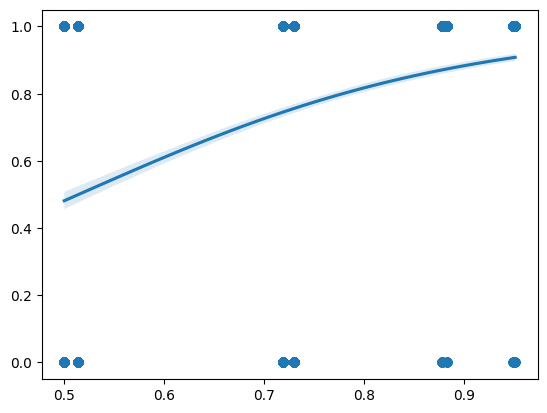

In [19]:
params = lr_model_syn.params
predictions = expit(synthetic_dfs_np[:,:-1] @ params)
sns.regplot(x=predictions[0:5000], y=synthetic_dfs_np[:,3][0:5000], logistic=True)

In [20]:
orig_df_np = orig_df.to_numpy()
X_array_orig = orig_df_np[:,:-1]
y_array_orig = orig_df_np[:,-1]
lr_model_orig =  sm.GLM(y_array_orig, X_array_orig, family=sm.families.Binomial()).fit()
print(lr_model_orig.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -45695.
Date:                Thu, 09 Mar 2023   Deviance:                       91390.
Time:                        15:54:57   Pearson chi2:                 9.99e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1592
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0169      0.015     69.995      0.0

In [21]:
np.unique(synthetic_dfs_np)

array([0, 1], dtype=int32)

<AxesSubplot:>

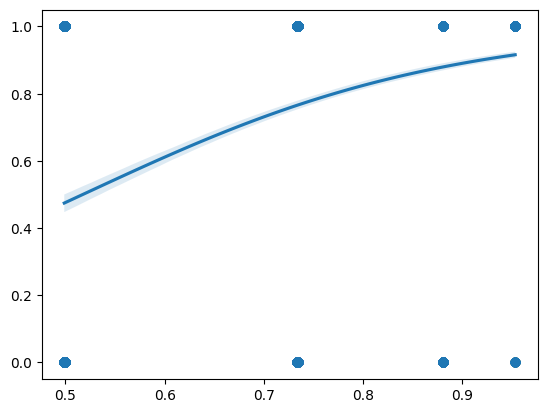

In [22]:
params_orig = lr_model_orig.params
predictions_orig = expit(orig_df_np[:,:-1] @ params_orig)

sns.regplot(x=predictions_orig[0:5000], y=orig_df_np[:,3][0:5000], logistic=True)

In [23]:
q = np.zeros((len(synthetic_dataset), 3))
u = np.zeros((len(synthetic_dataset), 3))

for i, syn_df in enumerate(synthetic_dataset):
    X_array_syn = syn_df.to_numpy()[:,:-1]
    y_array_syn = syn_df.to_numpy()[:,-1]
        
    logistic_regression_result_with_syn = sm.GLM(y_array_syn, X_array_syn, family=sm.families.Binomial()).fit()
    
    q[i, :] = logistic_regression_result_with_syn.params
    u[i, :] = logistic_regression_result_with_syn.bse**2
    
print(f"Expectation for param 1: {np.mean(q[:,0])}")
print(f"Expectation for param 2: {np.mean(q[:,1])}")
print(f"Expectation for param 3: {np.mean(q[:,2])}")
# print(f"Expectation for param 3: {np.mean(q[:,3])}")

Expectation for param 1: 0.9388998919953447
Expectation for param 2: 0.05454964515445632
Expectation for param 3: 1.9654335562673644


In [27]:
# How many repeats to calculate coverage
n_repeats = 20

confidence_intervals = np.round(np.linspace(0.05, 0.95, 5), 2)

n_datasets = [100]

true_params = original_params

In [28]:
@dataclass
class ConfidenceIntervalObject:
    original_dataset_name: str
    index: int
    n_datasets: int
    conf_int_range: float
    conf_int_start: float
    conf_int_end: float
    conf_int_width: float
    true_parameter_value: float
    contains_true_parameter: bool
    meta: dict
        
    def to_dict(self):
        return {
            'original_dataset_name': self.original_dataset_name,
            'index': self.index,
            'n_datasets': self.n_datasets,
            'conf_int_range': self.conf_int_range,
            'conf_int_start': self.conf_int_start,
            'conf_int_end': self.conf_int_end,
            'conf_int_width': self.conf_int_width,
            'true_parameter_value': self.true_parameter_value,
            'contains_true_parameter': self.contains_true_parameter,
            **self.meta
        }

In [29]:
rng = jax.random.PRNGKey(2356991365)
sampling_rngs = jax.random.split(rng, n_repeats * len(n_datasets))

ci_data_objects = []

for n in range(n_repeats):
    print(f"Round: {n}")
    for interval in confidence_intervals:
        for i, n_dataset in enumerate(n_datasets):
            print(f"Generating {n_dataset} datasets for interval {interval}")
            sampling_index = n + i
            datasets = model.generate(sampling_rngs[sampling_index], n_original_datapoints, n_dataset)
            datasets_np = dataframe_list_to_tensor(datasets)
            
            datasets_np = datasets_np.astype(int)
            
            q, u = logistic_regression(datasets_np, add_constant=False)
            
            for d in range(len(true_params)):
                q_i = q[:,d]
                u_i = u[:,d]
                
                inds = (np.isfinite(q_i) & np.isfinite(u_i))
                q_i = q_i[inds]
                u_i = u_i[inds]

                if len(u_i) == 0:
                    q_i = np.array(np.nan)
                    u_i = np.array(np.nan)
                
                ci_result = conf_int(q_i, u_i, interval)
                nn_ci_result = non_negative_conf_int(q_i, u_i, interval, n_original_datapoints * n_dataset, n_original_datapoints)
                
                if np.isnan(ci_result[0]) or np.isnan(ci_result[1]) or np.isnan(nn_ci_result[0]) or np.isnan(nn_ci_result[1]):
                    print(f"WARNING: Confidence interval had nan: {ci_result}, nn {nn_ci_result}")

                true_param_value = true_params[d]
                
                print(f"True param value: {true_param_value}, confidence interval: {ci_result[0]} - {ci_result[1]}, nn confidence interval: {nn_ci_result[0]} - {nn_ci_result[1]}")
                
                conf_int_object = ConfidenceIntervalObject(
                    original_dataset_name = dataset_name,
                    index = n,
                    n_datasets = n_dataset,
                    conf_int_range = interval,
                    conf_int_start = ci_result[0],
                    conf_int_end = ci_result[1],
                    conf_int_width = ci_result[1] - ci_result[0],
                    true_parameter_value = true_param_value,
                    contains_true_parameter = ci_result[0] <= true_param_value <= ci_result[1],
                    meta = {
                        'epsilon': model.meta['epsilon']
                    }
                )
                
                ci_data_objects.append(conf_int_object)
                
                print(conf_int_object.to_dict())

Round: 0
Generating 100 datasets for interval 0.05
Generating data with 100000 points and 100 datasets
True param value: 1.0168676479001293, confidence interval: 0.9352337330858603 - 0.9371514059817435, nn confidence interval: 0.9352337330858603 - 0.9371514059817435
{'original_dataset_name': 'binary4d', 'index': 0, 'n_datasets': 100, 'conf_int_range': 0.05, 'conf_int_start': 0.9352337330858603, 'conf_int_end': 0.9371514059817435, 'conf_int_width': 0.0019176728958831823, 'true_parameter_value': 1.0168676479001293, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: -0.004847484535803793, confidence interval: 0.05497238148247845 - 0.05665891566035267, nn confidence interval: 0.05497238148247845 - 0.05665891566035267
{'original_dataset_name': 'binary4d', 'index': 0, 'n_datasets': 100, 'conf_int_range': 0.05, 'conf_int_start': 0.05497238148247845, 'conf_int_end': 0.05665891566035267, 'conf_int_width': 0.0016865341778742257, 'true_parameter_value': -0.004847484535803793, 'co

True param value: 1.0168676479001293, confidence interval: 0.9318885386584203 - 0.9423547751553744, nn confidence interval: 0.9318885386584203 - 0.9423547751553744
{'original_dataset_name': 'binary4d', 'index': 1, 'n_datasets': 100, 'conf_int_range': 0.27, 'conf_int_start': 0.9318885386584203, 'conf_int_end': 0.9423547751553744, 'conf_int_width': 0.010466236496954107, 'true_parameter_value': 1.0168676479001293, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: -0.004847484535803793, confidence interval: 0.05210606246407222 - 0.06080781934274139, nn confidence interval: 0.05210606246407222 - 0.06080781934274139
{'original_dataset_name': 'binary4d', 'index': 1, 'n_datasets': 100, 'conf_int_range': 0.27, 'conf_int_start': 0.05210606246407222, 'conf_int_end': 0.06080781934274139, 'conf_int_width': 0.00870175687866917, 'true_parameter_value': -0.004847484535803793, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: 1.997028155391075, confidence interval: 1

True param value: 1.0168676479001293, confidence interval: 0.9243271937318716 - 0.9423228185355637, nn confidence interval: 0.9243271937318716 - 0.9423228185355637
{'original_dataset_name': 'binary4d', 'index': 2, 'n_datasets': 100, 'conf_int_range': 0.5, 'conf_int_start': 0.9243271937318716, 'conf_int_end': 0.9423228185355637, 'conf_int_width': 0.0179956248036921, 'true_parameter_value': 1.0168676479001293, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: -0.004847484535803793, confidence interval: 0.04673383366852112 - 0.06488095075065957, nn confidence interval: 0.04673383366852112 - 0.06488095075065957
{'original_dataset_name': 'binary4d', 'index': 2, 'n_datasets': 100, 'conf_int_range': 0.5, 'conf_int_start': 0.04673383366852112, 'conf_int_end': 0.06488095075065957, 'conf_int_width': 0.018147117082138446, 'true_parameter_value': -0.004847484535803793, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: 1.997028155391075, confidence interval: 1.95

True param value: 1.0168676479001293, confidence interval: 0.9219414330348428 - 0.9515458015951743, nn confidence interval: 0.9219414330348428 - 0.9515458015951743
{'original_dataset_name': 'binary4d', 'index': 3, 'n_datasets': 100, 'conf_int_range': 0.72, 'conf_int_start': 0.9219414330348428, 'conf_int_end': 0.9515458015951743, 'conf_int_width': 0.02960436856033155, 'true_parameter_value': 1.0168676479001293, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: -0.004847484535803793, confidence interval: 0.0396169740892101 - 0.06705523419635107, nn confidence interval: 0.0396169740892101 - 0.06705523419635107
{'original_dataset_name': 'binary4d', 'index': 3, 'n_datasets': 100, 'conf_int_range': 0.72, 'conf_int_start': 0.0396169740892101, 'conf_int_end': 0.06705523419635107, 'conf_int_width': 0.02743826010714097, 'true_parameter_value': -0.004847484535803793, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: 1.997028155391075, confidence interval: 1.948

True param value: 1.0168676479001293, confidence interval: 0.9112850684557019 - 0.9652746653535593, nn confidence interval: 0.9112850684557019 - 0.9652746653535593
{'original_dataset_name': 'binary4d', 'index': 4, 'n_datasets': 100, 'conf_int_range': 0.95, 'conf_int_start': 0.9112850684557019, 'conf_int_end': 0.9652746653535593, 'conf_int_width': 0.05398959689785743, 'true_parameter_value': 1.0168676479001293, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: -0.004847484535803793, confidence interval: 0.024751157677833382 - 0.08307089380321636, nn confidence interval: 0.024751157677833382 - 0.08307089380321636
{'original_dataset_name': 'binary4d', 'index': 4, 'n_datasets': 100, 'conf_int_range': 0.95, 'conf_int_start': 0.024751157677833382, 'conf_int_end': 0.08307089380321636, 'conf_int_width': 0.05831973612538298, 'true_parameter_value': -0.004847484535803793, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: 1.997028155391075, confidence interval:

True param value: 1.0168676479001293, confidence interval: 0.93792793283532 - 0.939565975214121, nn confidence interval: 0.93792793283532 - 0.939565975214121
{'original_dataset_name': 'binary4d', 'index': 6, 'n_datasets': 100, 'conf_int_range': 0.05, 'conf_int_start': 0.93792793283532, 'conf_int_end': 0.939565975214121, 'conf_int_width': 0.0016380423788009413, 'true_parameter_value': 1.0168676479001293, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: -0.004847484535803793, confidence interval: 0.0536040887289759 - 0.05523509094271065, nn confidence interval: 0.0536040887289759 - 0.05523509094271065
{'original_dataset_name': 'binary4d', 'index': 6, 'n_datasets': 100, 'conf_int_range': 0.05, 'conf_int_start': 0.0536040887289759, 'conf_int_end': 0.05523509094271065, 'conf_int_width': 0.0016310022137347516, 'true_parameter_value': -0.004847484535803793, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: 1.997028155391075, confidence interval: 1.96136060

True param value: 1.0168676479001293, confidence interval: 0.9316928916938612 - 0.939213561175283, nn confidence interval: 0.9316928916938612 - 0.939213561175283
{'original_dataset_name': 'binary4d', 'index': 7, 'n_datasets': 100, 'conf_int_range': 0.27, 'conf_int_start': 0.9316928916938612, 'conf_int_end': 0.939213561175283, 'conf_int_width': 0.007520669481421827, 'true_parameter_value': 1.0168676479001293, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: -0.004847484535803793, confidence interval: 0.05411218115170746 - 0.05967231395563752, nn confidence interval: 0.05411218115170746 - 0.05967231395563752
{'original_dataset_name': 'binary4d', 'index': 7, 'n_datasets': 100, 'conf_int_range': 0.27, 'conf_int_start': 0.05411218115170746, 'conf_int_end': 0.05967231395563752, 'conf_int_width': 0.005560132803930057, 'true_parameter_value': -0.004847484535803793, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: 1.997028155391075, confidence interval: 1.9

True param value: 1.0168676479001293, confidence interval: 0.9279552053407459 - 0.9465515274529887, nn confidence interval: 0.9279552053407459 - 0.9465515274529887
{'original_dataset_name': 'binary4d', 'index': 8, 'n_datasets': 100, 'conf_int_range': 0.5, 'conf_int_start': 0.9279552053407459, 'conf_int_end': 0.9465515274529887, 'conf_int_width': 0.018596322112242714, 'true_parameter_value': 1.0168676479001293, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: -0.004847484535803793, confidence interval: 0.048276366826256405 - 0.0607496213017649, nn confidence interval: 0.048276366826256405 - 0.0607496213017649
{'original_dataset_name': 'binary4d', 'index': 8, 'n_datasets': 100, 'conf_int_range': 0.5, 'conf_int_start': 0.048276366826256405, 'conf_int_end': 0.0607496213017649, 'conf_int_width': 0.012473254475508497, 'true_parameter_value': -0.004847484535803793, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: 1.997028155391075, confidence interval: 1.

True param value: 1.0168676479001293, confidence interval: 0.9177624202719983 - 0.9488000505406609, nn confidence interval: 0.9177624202719983 - 0.9488000505406609
{'original_dataset_name': 'binary4d', 'index': 9, 'n_datasets': 100, 'conf_int_range': 0.72, 'conf_int_start': 0.9177624202719983, 'conf_int_end': 0.9488000505406609, 'conf_int_width': 0.031037630268662575, 'true_parameter_value': 1.0168676479001293, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: -0.004847484535803793, confidence interval: 0.042600277757590344 - 0.06989180699732837, nn confidence interval: 0.042600277757590344 - 0.06989180699732837
{'original_dataset_name': 'binary4d', 'index': 9, 'n_datasets': 100, 'conf_int_range': 0.72, 'conf_int_start': 0.042600277757590344, 'conf_int_end': 0.06989180699732837, 'conf_int_width': 0.02729152923973803, 'true_parameter_value': -0.004847484535803793, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: 1.997028155391075, confidence interval

True param value: 1.0168676479001293, confidence interval: 0.9079139929458451 - 0.9639432514012338, nn confidence interval: 0.9079139929458451 - 0.9639432514012338
{'original_dataset_name': 'binary4d', 'index': 10, 'n_datasets': 100, 'conf_int_range': 0.95, 'conf_int_start': 0.9079139929458451, 'conf_int_end': 0.9639432514012338, 'conf_int_width': 0.05602925845538875, 'true_parameter_value': 1.0168676479001293, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: -0.004847484535803793, confidence interval: 0.030595603539918175 - 0.07125139275511615, nn confidence interval: 0.030595603539918175 - 0.07125139275511615
{'original_dataset_name': 'binary4d', 'index': 10, 'n_datasets': 100, 'conf_int_range': 0.95, 'conf_int_start': 0.030595603539918175, 'conf_int_end': 0.07125139275511615, 'conf_int_width': 0.04065578921519797, 'true_parameter_value': -0.004847484535803793, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: 1.997028155391075, confidence interva

True param value: 1.0168676479001293, confidence interval: 0.9344181450275354 - 0.9359910272461879, nn confidence interval: 0.9344181450275354 - 0.9359910272461879
{'original_dataset_name': 'binary4d', 'index': 12, 'n_datasets': 100, 'conf_int_range': 0.05, 'conf_int_start': 0.9344181450275354, 'conf_int_end': 0.9359910272461879, 'conf_int_width': 0.0015728822186524827, 'true_parameter_value': 1.0168676479001293, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: -0.004847484535803793, confidence interval: 0.054841178133368154 - 0.05660920892555375, nn confidence interval: 0.054841178133368154 - 0.05660920892555375
{'original_dataset_name': 'binary4d', 'index': 12, 'n_datasets': 100, 'conf_int_range': 0.05, 'conf_int_start': 0.054841178133368154, 'conf_int_end': 0.05660920892555375, 'conf_int_width': 0.0017680307921855987, 'true_parameter_value': -0.004847484535803793, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: 1.997028155391075, confidence int

True param value: 1.0168676479001293, confidence interval: 0.9319588447349415 - 0.9410853607271251, nn confidence interval: 0.9319588447349415 - 0.9410853607271251
{'original_dataset_name': 'binary4d', 'index': 13, 'n_datasets': 100, 'conf_int_range': 0.27, 'conf_int_start': 0.9319588447349415, 'conf_int_end': 0.9410853607271251, 'conf_int_width': 0.009126515992183615, 'true_parameter_value': 1.0168676479001293, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: -0.004847484535803793, confidence interval: 0.051469766876156946 - 0.05715924495317514, nn confidence interval: 0.051469766876156946 - 0.05715924495317514
{'original_dataset_name': 'binary4d', 'index': 13, 'n_datasets': 100, 'conf_int_range': 0.27, 'conf_int_start': 0.051469766876156946, 'conf_int_end': 0.05715924495317514, 'conf_int_width': 0.005689478077018195, 'true_parameter_value': -0.004847484535803793, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: 1.997028155391075, confidence inter

True param value: 1.0168676479001293, confidence interval: 0.9289726637829379 - 0.9470361584944571, nn confidence interval: 0.9289726637829379 - 0.9470361584944571
{'original_dataset_name': 'binary4d', 'index': 14, 'n_datasets': 100, 'conf_int_range': 0.5, 'conf_int_start': 0.9289726637829379, 'conf_int_end': 0.9470361584944571, 'conf_int_width': 0.018063494711519246, 'true_parameter_value': 1.0168676479001293, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: -0.004847484535803793, confidence interval: 0.04426252183541113 - 0.06194974654375032, nn confidence interval: 0.04426252183541113 - 0.06194974654375032
{'original_dataset_name': 'binary4d', 'index': 14, 'n_datasets': 100, 'conf_int_range': 0.5, 'conf_int_start': 0.04426252183541113, 'conf_int_end': 0.06194974654375032, 'conf_int_width': 0.017687224708339194, 'true_parameter_value': -0.004847484535803793, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: 1.997028155391075, confidence interval: 

True param value: 1.0168676479001293, confidence interval: 0.9270603252450152 - 0.9546890886434901, nn confidence interval: 0.9270603252450152 - 0.9546890886434901
{'original_dataset_name': 'binary4d', 'index': 15, 'n_datasets': 100, 'conf_int_range': 0.72, 'conf_int_start': 0.9270603252450152, 'conf_int_end': 0.9546890886434901, 'conf_int_width': 0.027628763398474865, 'true_parameter_value': 1.0168676479001293, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: -0.004847484535803793, confidence interval: 0.036641769692631034 - 0.06435846043630118, nn confidence interval: 0.036641769692631034 - 0.06435846043630118
{'original_dataset_name': 'binary4d', 'index': 15, 'n_datasets': 100, 'conf_int_range': 0.72, 'conf_int_start': 0.036641769692631034, 'conf_int_end': 0.06435846043630118, 'conf_int_width': 0.02771669074367015, 'true_parameter_value': -0.004847484535803793, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: 1.997028155391075, confidence interv

True param value: 1.0168676479001293, confidence interval: 0.9096423043096228 - 0.9671306574553452, nn confidence interval: 0.9096423043096228 - 0.9671306574553452
{'original_dataset_name': 'binary4d', 'index': 16, 'n_datasets': 100, 'conf_int_range': 0.95, 'conf_int_start': 0.9096423043096228, 'conf_int_end': 0.9671306574553452, 'conf_int_width': 0.057488353145722426, 'true_parameter_value': 1.0168676479001293, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: -0.004847484535803793, confidence interval: 0.0327521156039159 - 0.08200278550801908, nn confidence interval: 0.0327521156039159 - 0.08200278550801908
{'original_dataset_name': 'binary4d', 'index': 16, 'n_datasets': 100, 'conf_int_range': 0.95, 'conf_int_start': 0.0327521156039159, 'conf_int_end': 0.08200278550801908, 'conf_int_width': 0.04925066990410318, 'true_parameter_value': -0.004847484535803793, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: 1.997028155391075, confidence interval: 1.

True param value: 1.0168676479001293, confidence interval: 0.9368032486499824 - 0.9382778944929189, nn confidence interval: 0.9368032486499824 - 0.9382778944929189
{'original_dataset_name': 'binary4d', 'index': 18, 'n_datasets': 100, 'conf_int_range': 0.05, 'conf_int_start': 0.9368032486499824, 'conf_int_end': 0.9382778944929189, 'conf_int_width': 0.0014746458429364395, 'true_parameter_value': 1.0168676479001293, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: -0.004847484535803793, confidence interval: 0.05247543320721611 - 0.05431116151724541, nn confidence interval: 0.05247543320721611 - 0.05431116151724541
{'original_dataset_name': 'binary4d', 'index': 18, 'n_datasets': 100, 'conf_int_range': 0.05, 'conf_int_start': 0.05247543320721611, 'conf_int_end': 0.05431116151724541, 'conf_int_width': 0.0018357283100293026, 'true_parameter_value': -0.004847484535803793, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: 1.997028155391075, confidence interv

True param value: 1.0168676479001293, confidence interval: 0.9306040520129607 - 0.9391380689674428, nn confidence interval: 0.9306040520129607 - 0.9391380689674428
{'original_dataset_name': 'binary4d', 'index': 19, 'n_datasets': 100, 'conf_int_range': 0.27, 'conf_int_start': 0.9306040520129607, 'conf_int_end': 0.9391380689674428, 'conf_int_width': 0.008534016954482082, 'true_parameter_value': 1.0168676479001293, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: -0.004847484535803793, confidence interval: 0.051113424210835125 - 0.05898072340516262, nn confidence interval: 0.051113424210835125 - 0.05898072340516262
{'original_dataset_name': 'binary4d', 'index': 19, 'n_datasets': 100, 'conf_int_range': 0.27, 'conf_int_start': 0.051113424210835125, 'conf_int_end': 0.05898072340516262, 'conf_int_width': 0.007867299194327493, 'true_parameter_value': -0.004847484535803793, 'contains_true_parameter': False, 'epsilon': 8.0}
True param value: 1.997028155391075, confidence inter

In [30]:
ci_data_df = pd.DataFrame.from_records([obj.to_dict() for obj in ci_data_objects])

In [31]:
ci_data_df

,original_dataset_name,index,n_datasets,conf_int_range,conf_int_start,conf_int_end,conf_int_width,true_parameter_value,contains_true_parameter,epsilon
0,binary4d,0,100,0.05,0.935234,0.937151,0.001918,1.016868,False,8.0
1,binary4d,0,100,0.05,0.054972,0.056659,0.001687,-0.004847,False,8.0
2,binary4d,0,100,0.05,1.963049,1.965152,0.002103,1.997028,False,8.0
3,binary4d,0,100,0.27,0.930910,0.941476,0.010566,1.016868,False,8.0
4,binary4d,0,100,0.27,0.051169,0.060462,0.009293,-0.004847,False,8.0
...,...,...,...,...,...,...,...,...,...,...
295,binary4d,19,100,0.72,0.042534,0.067560,0.025026,-0.004847,False,8.0
296,binary4d,19,100,0.72,1.949865,1.983131,0.033266,1.997028,False,8.0
297,binary4d,19,100,0.95,0.909187,0.960556,0.051369,1.016868,False,8.0
298,binary4d,19,100,0.95,0.031375,0.078719,0.047345,-0.004847,False,8.0


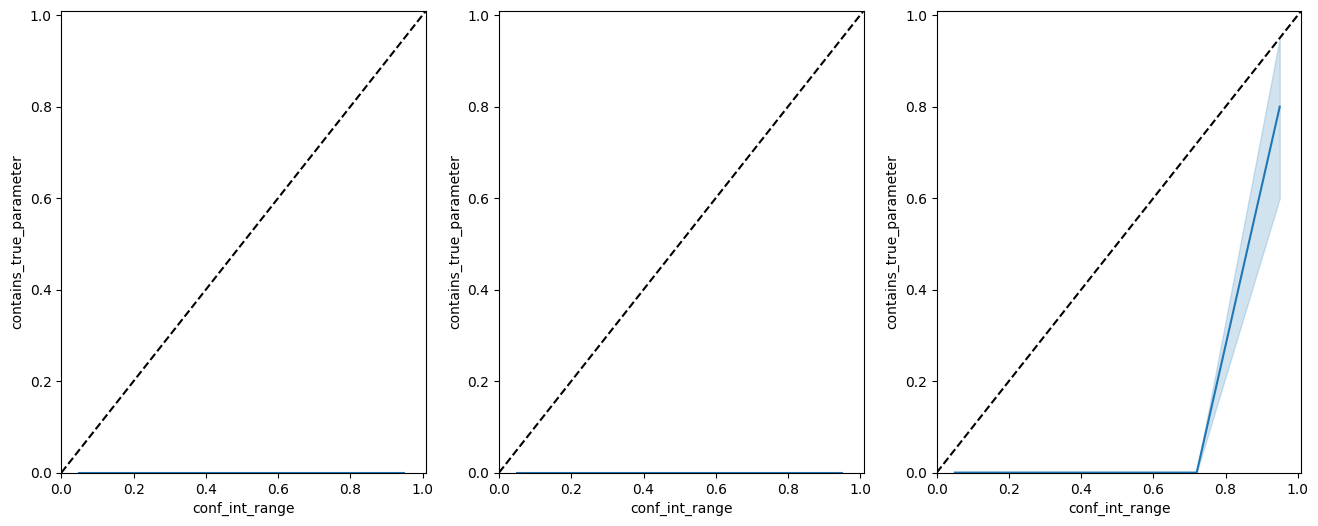

In [32]:
fig, axes = plt.subplots(1, len(true_params), figsize=(16, 6))

for i, param in enumerate(true_params):
    ax = axes[i]
    ci_data = ci_data_df[ci_data_df['true_parameter_value'] == param]
    sns.lineplot(x="conf_int_range", y="contains_true_parameter", markers=True, err_style="band", data=ci_data, ax=ax)
    diag = (0.0, 1.01)
    ax.plot(diag, diag, linestyle="dashed", color="black")
    ax.set_xlim(diag)
    ax.set_ylim(diag)
    #axes[0, i].set_title(f"True parameter: {param}")
    #axes[-1, i].set_xlabel("Conf Level")